In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
output_notebook()
%matplotlib inline

Loading BokehJS ...

### Dados
- são carregados os dados pre-procesados no notebook: <i>Data pre-processing</i>

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [3]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [4]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [5]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r
    

In [6]:
np.min(X_rg)

BB9     5.692781
BB10    5.733848
BB17    5.686571
BB19    5.735536
BB20    6.016590
BB21    6.131968
BB11    6.113390
BB12    5.891730
BB18    5.822536
dtype: float64

In [7]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [8]:
X_cand = datos.drop(rg)
X_cand.shape

(4168, 9)

In [9]:

X_cand.shape

(4168, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [11]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dropout(.15))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [12]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [13]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [14]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [26]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input, verbose=True):
    g_loss = []
    d_loss = []
    precision = []
    recall = []
    kl_d = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (2*batch.shape[0], noise_input))
            y_mislabled = np.ones((2*batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        y_proba = D.predict_proba(X_comb)
        kl_d.append(np.mean((1-y_proba)*np.log((1-y_proba)/y_proba)))
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        recall.append(recall_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()

        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        if verbose:
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))

    return g_loss, d_loss, precision, recall, kl_d

In [30]:
noise_input = 50
ep = 1750
#Gerador
optimizerG = SGD(lr=0.00014, momentum=0.92, decay=0.00014/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_9 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_10 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


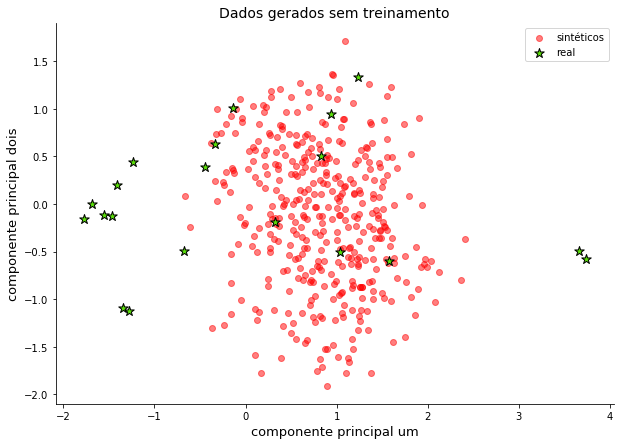

In [31]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(0, 1, size=(X_train.shape[0]*20, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.5)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [32]:
g_loss, d_loss, precision, recall, kld = train(X_train, epochs=1750, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/1750] [Discriminator::d_loss: 0.676572],[Generator::loss: 0.757078], 0.583671[sec]
epoch:[2/1750] [Discriminator::d_loss: 0.696699],[Generator::loss: 0.747293], 0.088066[sec]
epoch:[3/1750] [Discriminator::d_loss: 0.696972],[Generator::loss: 0.749405], 0.087795[sec]
epoch:[4/1750] [Discriminator::d_loss: 0.687534],[Generator::loss: 0.753580], 0.099876[sec]
epoch:[5/1750] [Discriminator::d_loss: 0.711516],[Generator::loss: 0.715909], 0.087590[sec]
epoch:[6/1750] [Discriminator::d_loss: 0.662189],[Generator::loss: 0.715094], 0.087200[sec]
epoch:[7/1750] [Discriminator::d_loss: 0.682830],[Generator::loss: 0.740735], 0.108873[sec]
epoch:[8/1750] [Discriminator::d_loss: 0.654083],[Generator::loss: 0.697060], 0.092440[sec]
epoch:[9/1750] [Discriminator::d_loss: 0.720241],[Generator::loss: 0.741017], 0.100312[sec]
epoch:[10/1750] [Discriminator::d_loss: 0.704814],[Generator::loss: 0.766920], 0.146809[sec]
epoch:[11/1750] [Discriminator::d_loss: 0.698859],[Generator::loss: 0.679492], 

epoch:[90/1750] [Discriminator::d_loss: 0.653680],[Generator::loss: 0.772480], 0.092078[sec]
epoch:[91/1750] [Discriminator::d_loss: 0.654918],[Generator::loss: 0.716294], 0.098473[sec]
epoch:[92/1750] [Discriminator::d_loss: 0.646083],[Generator::loss: 0.766834], 0.104718[sec]
epoch:[93/1750] [Discriminator::d_loss: 0.639669],[Generator::loss: 0.813659], 0.096712[sec]
epoch:[94/1750] [Discriminator::d_loss: 0.616263],[Generator::loss: 0.762111], 0.084799[sec]
epoch:[95/1750] [Discriminator::d_loss: 0.637081],[Generator::loss: 0.711472], 0.100116[sec]
epoch:[96/1750] [Discriminator::d_loss: 0.623742],[Generator::loss: 0.697841], 0.087580[sec]
epoch:[97/1750] [Discriminator::d_loss: 0.663619],[Generator::loss: 0.755493], 0.090850[sec]
epoch:[98/1750] [Discriminator::d_loss: 0.632025],[Generator::loss: 0.754254], 0.097063[sec]
epoch:[99/1750] [Discriminator::d_loss: 0.640849],[Generator::loss: 0.725201], 0.089319[sec]
epoch:[100/1750] [Discriminator::d_loss: 0.638847],[Generator::loss: 0

epoch:[178/1750] [Discriminator::d_loss: 0.603927],[Generator::loss: 0.744388], 0.100488[sec]
epoch:[179/1750] [Discriminator::d_loss: 0.620175],[Generator::loss: 0.751071], 0.120537[sec]
epoch:[180/1750] [Discriminator::d_loss: 0.637740],[Generator::loss: 0.793191], 0.179866[sec]
epoch:[181/1750] [Discriminator::d_loss: 0.622689],[Generator::loss: 0.742948], 0.148309[sec]
epoch:[182/1750] [Discriminator::d_loss: 0.624470],[Generator::loss: 0.754243], 0.156192[sec]
epoch:[183/1750] [Discriminator::d_loss: 0.604161],[Generator::loss: 0.778118], 0.148728[sec]
epoch:[184/1750] [Discriminator::d_loss: 0.585177],[Generator::loss: 0.840081], 0.126184[sec]
epoch:[185/1750] [Discriminator::d_loss: 0.603703],[Generator::loss: 0.803567], 0.121548[sec]
epoch:[186/1750] [Discriminator::d_loss: 0.612540],[Generator::loss: 0.739124], 0.159072[sec]
epoch:[187/1750] [Discriminator::d_loss: 0.608637],[Generator::loss: 0.796310], 0.148222[sec]
epoch:[188/1750] [Discriminator::d_loss: 0.634667],[Generato

epoch:[267/1750] [Discriminator::d_loss: 0.589467],[Generator::loss: 0.746854], 0.117397[sec]
epoch:[268/1750] [Discriminator::d_loss: 0.561976],[Generator::loss: 0.857813], 0.101962[sec]
epoch:[269/1750] [Discriminator::d_loss: 0.592751],[Generator::loss: 0.844411], 0.093405[sec]
epoch:[270/1750] [Discriminator::d_loss: 0.604086],[Generator::loss: 0.782287], 0.137891[sec]
epoch:[271/1750] [Discriminator::d_loss: 0.568829],[Generator::loss: 0.761279], 0.092415[sec]
epoch:[272/1750] [Discriminator::d_loss: 0.587008],[Generator::loss: 0.801989], 0.091786[sec]
epoch:[273/1750] [Discriminator::d_loss: 0.590306],[Generator::loss: 0.821475], 0.112710[sec]
epoch:[274/1750] [Discriminator::d_loss: 0.564835],[Generator::loss: 0.772837], 0.110861[sec]
epoch:[275/1750] [Discriminator::d_loss: 0.576119],[Generator::loss: 0.849263], 0.116191[sec]
epoch:[276/1750] [Discriminator::d_loss: 0.566061],[Generator::loss: 0.800049], 0.096556[sec]
epoch:[277/1750] [Discriminator::d_loss: 0.585734],[Generato

epoch:[357/1750] [Discriminator::d_loss: 0.565663],[Generator::loss: 0.833842], 0.086800[sec]
epoch:[358/1750] [Discriminator::d_loss: 0.597967],[Generator::loss: 0.906027], 0.085052[sec]
epoch:[359/1750] [Discriminator::d_loss: 0.557968],[Generator::loss: 0.803357], 0.092975[sec]
epoch:[360/1750] [Discriminator::d_loss: 0.561616],[Generator::loss: 0.790302], 0.090392[sec]
epoch:[361/1750] [Discriminator::d_loss: 0.570426],[Generator::loss: 0.842057], 0.090297[sec]
epoch:[362/1750] [Discriminator::d_loss: 0.530964],[Generator::loss: 0.883575], 0.087531[sec]
epoch:[363/1750] [Discriminator::d_loss: 0.573142],[Generator::loss: 0.909047], 0.087443[sec]
epoch:[364/1750] [Discriminator::d_loss: 0.540108],[Generator::loss: 0.789752], 0.090580[sec]
epoch:[365/1750] [Discriminator::d_loss: 0.559555],[Generator::loss: 0.901430], 0.087308[sec]
epoch:[366/1750] [Discriminator::d_loss: 0.543464],[Generator::loss: 0.841533], 0.094334[sec]
epoch:[367/1750] [Discriminator::d_loss: 0.547461],[Generato

epoch:[445/1750] [Discriminator::d_loss: 0.574288],[Generator::loss: 0.879267], 0.086858[sec]
epoch:[446/1750] [Discriminator::d_loss: 0.551590],[Generator::loss: 0.865043], 0.089444[sec]
epoch:[447/1750] [Discriminator::d_loss: 0.576023],[Generator::loss: 0.793796], 0.091465[sec]
epoch:[448/1750] [Discriminator::d_loss: 0.607758],[Generator::loss: 0.868584], 0.094870[sec]
epoch:[449/1750] [Discriminator::d_loss: 0.556165],[Generator::loss: 0.838193], 0.097915[sec]
epoch:[450/1750] [Discriminator::d_loss: 0.576689],[Generator::loss: 0.896452], 0.086589[sec]
epoch:[451/1750] [Discriminator::d_loss: 0.565802],[Generator::loss: 0.881757], 0.098345[sec]
epoch:[452/1750] [Discriminator::d_loss: 0.592205],[Generator::loss: 0.836955], 0.094414[sec]
epoch:[453/1750] [Discriminator::d_loss: 0.562109],[Generator::loss: 0.898524], 0.087346[sec]
epoch:[454/1750] [Discriminator::d_loss: 0.540185],[Generator::loss: 0.850803], 0.090053[sec]
epoch:[455/1750] [Discriminator::d_loss: 0.557174],[Generato

epoch:[533/1750] [Discriminator::d_loss: 0.558331],[Generator::loss: 0.874526], 0.092350[sec]
epoch:[534/1750] [Discriminator::d_loss: 0.590650],[Generator::loss: 0.944074], 0.086066[sec]
epoch:[535/1750] [Discriminator::d_loss: 0.542231],[Generator::loss: 0.900125], 0.090393[sec]
epoch:[536/1750] [Discriminator::d_loss: 0.534017],[Generator::loss: 0.884190], 0.085686[sec]
epoch:[537/1750] [Discriminator::d_loss: 0.590515],[Generator::loss: 0.887196], 0.088581[sec]
epoch:[538/1750] [Discriminator::d_loss: 0.560194],[Generator::loss: 0.935698], 0.095249[sec]
epoch:[539/1750] [Discriminator::d_loss: 0.533647],[Generator::loss: 0.877694], 0.094339[sec]
epoch:[540/1750] [Discriminator::d_loss: 0.526901],[Generator::loss: 0.903424], 0.089477[sec]
epoch:[541/1750] [Discriminator::d_loss: 0.574738],[Generator::loss: 0.922792], 0.092938[sec]
epoch:[542/1750] [Discriminator::d_loss: 0.568757],[Generator::loss: 0.989976], 0.095187[sec]
epoch:[543/1750] [Discriminator::d_loss: 0.517708],[Generato

epoch:[623/1750] [Discriminator::d_loss: 0.595802],[Generator::loss: 0.909514], 0.095819[sec]
epoch:[624/1750] [Discriminator::d_loss: 0.549280],[Generator::loss: 0.967517], 0.092242[sec]
epoch:[625/1750] [Discriminator::d_loss: 0.578856],[Generator::loss: 0.930415], 0.091104[sec]
epoch:[626/1750] [Discriminator::d_loss: 0.531440],[Generator::loss: 0.918880], 0.085228[sec]
epoch:[627/1750] [Discriminator::d_loss: 0.546439],[Generator::loss: 0.852770], 0.084549[sec]
epoch:[628/1750] [Discriminator::d_loss: 0.570954],[Generator::loss: 0.918087], 0.089908[sec]
epoch:[629/1750] [Discriminator::d_loss: 0.612607],[Generator::loss: 0.910584], 0.090343[sec]
epoch:[630/1750] [Discriminator::d_loss: 0.540270],[Generator::loss: 0.914334], 0.094230[sec]
epoch:[631/1750] [Discriminator::d_loss: 0.545040],[Generator::loss: 0.911413], 0.095104[sec]
epoch:[632/1750] [Discriminator::d_loss: 0.540047],[Generator::loss: 0.903492], 0.087171[sec]
epoch:[633/1750] [Discriminator::d_loss: 0.575408],[Generato

epoch:[711/1750] [Discriminator::d_loss: 0.612477],[Generator::loss: 0.951667], 0.093853[sec]
epoch:[712/1750] [Discriminator::d_loss: 0.580617],[Generator::loss: 0.881760], 0.087303[sec]
epoch:[713/1750] [Discriminator::d_loss: 0.604169],[Generator::loss: 0.930052], 0.086746[sec]
epoch:[714/1750] [Discriminator::d_loss: 0.582497],[Generator::loss: 0.853325], 0.107578[sec]
epoch:[715/1750] [Discriminator::d_loss: 0.583474],[Generator::loss: 0.863483], 0.089124[sec]
epoch:[716/1750] [Discriminator::d_loss: 0.551791],[Generator::loss: 1.023080], 0.094442[sec]
epoch:[717/1750] [Discriminator::d_loss: 0.570330],[Generator::loss: 0.929044], 0.087902[sec]
epoch:[718/1750] [Discriminator::d_loss: 0.590414],[Generator::loss: 0.944405], 0.091889[sec]
epoch:[719/1750] [Discriminator::d_loss: 0.557287],[Generator::loss: 0.929943], 0.233886[sec]
epoch:[720/1750] [Discriminator::d_loss: 0.564499],[Generator::loss: 0.926088], 0.085825[sec]
epoch:[721/1750] [Discriminator::d_loss: 0.571068],[Generato

epoch:[801/1750] [Discriminator::d_loss: 0.545111],[Generator::loss: 0.870637], 0.088190[sec]
epoch:[802/1750] [Discriminator::d_loss: 0.573810],[Generator::loss: 0.977808], 0.091105[sec]
epoch:[803/1750] [Discriminator::d_loss: 0.562086],[Generator::loss: 0.901067], 0.086789[sec]
epoch:[804/1750] [Discriminator::d_loss: 0.601148],[Generator::loss: 0.874975], 0.094774[sec]
epoch:[805/1750] [Discriminator::d_loss: 0.656147],[Generator::loss: 0.934505], 0.085230[sec]
epoch:[806/1750] [Discriminator::d_loss: 0.661770],[Generator::loss: 1.025678], 0.093199[sec]
epoch:[807/1750] [Discriminator::d_loss: 0.596139],[Generator::loss: 0.863136], 0.087704[sec]
epoch:[808/1750] [Discriminator::d_loss: 0.586364],[Generator::loss: 0.917724], 0.085394[sec]
epoch:[809/1750] [Discriminator::d_loss: 0.656762],[Generator::loss: 0.921826], 0.092195[sec]
epoch:[810/1750] [Discriminator::d_loss: 0.593951],[Generator::loss: 0.814059], 0.095473[sec]
epoch:[811/1750] [Discriminator::d_loss: 0.614224],[Generato

epoch:[890/1750] [Discriminator::d_loss: 0.622175],[Generator::loss: 0.884654], 0.104216[sec]
epoch:[891/1750] [Discriminator::d_loss: 0.605602],[Generator::loss: 0.867988], 0.100741[sec]
epoch:[892/1750] [Discriminator::d_loss: 0.628567],[Generator::loss: 0.856797], 0.104207[sec]
epoch:[893/1750] [Discriminator::d_loss: 0.741736],[Generator::loss: 0.823060], 0.087195[sec]
epoch:[894/1750] [Discriminator::d_loss: 0.589973],[Generator::loss: 0.892833], 0.084424[sec]
epoch:[895/1750] [Discriminator::d_loss: 0.655272],[Generator::loss: 0.883867], 0.099489[sec]
epoch:[896/1750] [Discriminator::d_loss: 0.702695],[Generator::loss: 0.971125], 0.091698[sec]
epoch:[897/1750] [Discriminator::d_loss: 0.628503],[Generator::loss: 0.941044], 0.089409[sec]
epoch:[898/1750] [Discriminator::d_loss: 0.634487],[Generator::loss: 0.862504], 0.086315[sec]
epoch:[899/1750] [Discriminator::d_loss: 0.647178],[Generator::loss: 0.850515], 0.085059[sec]
epoch:[900/1750] [Discriminator::d_loss: 0.685868],[Generato

epoch:[979/1750] [Discriminator::d_loss: 0.618448],[Generator::loss: 0.811246], 0.109234[sec]
epoch:[980/1750] [Discriminator::d_loss: 0.673635],[Generator::loss: 0.878645], 0.093235[sec]
epoch:[981/1750] [Discriminator::d_loss: 0.684109],[Generator::loss: 0.894647], 0.089956[sec]
epoch:[982/1750] [Discriminator::d_loss: 0.756344],[Generator::loss: 0.897866], 0.088412[sec]
epoch:[983/1750] [Discriminator::d_loss: 0.595853],[Generator::loss: 0.884528], 0.091219[sec]
epoch:[984/1750] [Discriminator::d_loss: 0.703182],[Generator::loss: 0.909755], 0.092959[sec]
epoch:[985/1750] [Discriminator::d_loss: 0.719412],[Generator::loss: 0.945056], 0.090654[sec]
epoch:[986/1750] [Discriminator::d_loss: 0.636255],[Generator::loss: 0.795255], 0.092513[sec]
epoch:[987/1750] [Discriminator::d_loss: 0.640751],[Generator::loss: 0.820401], 0.095562[sec]
epoch:[988/1750] [Discriminator::d_loss: 0.643641],[Generator::loss: 0.837141], 0.103688[sec]
epoch:[989/1750] [Discriminator::d_loss: 0.684372],[Generato

epoch:[1068/1750] [Discriminator::d_loss: 0.726827],[Generator::loss: 0.919690], 0.098971[sec]
epoch:[1069/1750] [Discriminator::d_loss: 0.674150],[Generator::loss: 0.873213], 0.084261[sec]
epoch:[1070/1750] [Discriminator::d_loss: 0.719683],[Generator::loss: 0.909280], 0.085028[sec]
epoch:[1071/1750] [Discriminator::d_loss: 0.654667],[Generator::loss: 0.947909], 0.090899[sec]
epoch:[1072/1750] [Discriminator::d_loss: 0.707833],[Generator::loss: 0.883085], 0.084519[sec]
epoch:[1073/1750] [Discriminator::d_loss: 0.645244],[Generator::loss: 0.837881], 0.095432[sec]
epoch:[1074/1750] [Discriminator::d_loss: 0.651363],[Generator::loss: 0.819761], 0.088283[sec]
epoch:[1075/1750] [Discriminator::d_loss: 0.723611],[Generator::loss: 0.945349], 0.087615[sec]
epoch:[1076/1750] [Discriminator::d_loss: 0.698490],[Generator::loss: 0.799395], 0.089755[sec]
epoch:[1077/1750] [Discriminator::d_loss: 0.674206],[Generator::loss: 0.860535], 0.086493[sec]
epoch:[1078/1750] [Discriminator::d_loss: 0.684846

epoch:[1156/1750] [Discriminator::d_loss: 0.768643],[Generator::loss: 0.876216], 0.098812[sec]
epoch:[1157/1750] [Discriminator::d_loss: 0.695672],[Generator::loss: 0.837907], 0.091726[sec]
epoch:[1158/1750] [Discriminator::d_loss: 0.697773],[Generator::loss: 0.784471], 0.086693[sec]
epoch:[1159/1750] [Discriminator::d_loss: 0.689692],[Generator::loss: 0.822726], 0.093902[sec]
epoch:[1160/1750] [Discriminator::d_loss: 0.737422],[Generator::loss: 0.852881], 0.084619[sec]
epoch:[1161/1750] [Discriminator::d_loss: 0.737552],[Generator::loss: 0.800245], 0.089662[sec]
epoch:[1162/1750] [Discriminator::d_loss: 0.747152],[Generator::loss: 0.888847], 0.087414[sec]
epoch:[1163/1750] [Discriminator::d_loss: 0.671618],[Generator::loss: 0.874612], 0.098193[sec]
epoch:[1164/1750] [Discriminator::d_loss: 0.657230],[Generator::loss: 0.812821], 0.090761[sec]
epoch:[1165/1750] [Discriminator::d_loss: 0.658363],[Generator::loss: 0.891674], 0.088643[sec]
epoch:[1166/1750] [Discriminator::d_loss: 0.746446

epoch:[1244/1750] [Discriminator::d_loss: 0.718368],[Generator::loss: 0.890383], 0.091343[sec]
epoch:[1245/1750] [Discriminator::d_loss: 0.660946],[Generator::loss: 0.814377], 0.155202[sec]
epoch:[1246/1750] [Discriminator::d_loss: 0.631081],[Generator::loss: 0.828954], 0.123045[sec]
epoch:[1247/1750] [Discriminator::d_loss: 0.691098],[Generator::loss: 0.791933], 0.116881[sec]
epoch:[1248/1750] [Discriminator::d_loss: 0.680611],[Generator::loss: 0.829649], 0.102849[sec]
epoch:[1249/1750] [Discriminator::d_loss: 0.775206],[Generator::loss: 0.828196], 0.088869[sec]
epoch:[1250/1750] [Discriminator::d_loss: 0.687452],[Generator::loss: 0.852078], 0.085105[sec]
epoch:[1251/1750] [Discriminator::d_loss: 0.659265],[Generator::loss: 0.797954], 0.093324[sec]
epoch:[1252/1750] [Discriminator::d_loss: 0.736904],[Generator::loss: 0.893291], 0.100153[sec]
epoch:[1253/1750] [Discriminator::d_loss: 0.694403],[Generator::loss: 0.818492], 0.086869[sec]
epoch:[1254/1750] [Discriminator::d_loss: 0.649289

epoch:[1333/1750] [Discriminator::d_loss: 0.705841],[Generator::loss: 0.899566], 0.085970[sec]
epoch:[1334/1750] [Discriminator::d_loss: 0.724767],[Generator::loss: 0.837704], 0.085432[sec]
epoch:[1335/1750] [Discriminator::d_loss: 0.697188],[Generator::loss: 0.848259], 0.091023[sec]
epoch:[1336/1750] [Discriminator::d_loss: 0.657477],[Generator::loss: 0.777587], 0.087660[sec]
epoch:[1337/1750] [Discriminator::d_loss: 0.716282],[Generator::loss: 0.753710], 0.095889[sec]
epoch:[1338/1750] [Discriminator::d_loss: 0.730387],[Generator::loss: 0.848217], 0.091967[sec]
epoch:[1339/1750] [Discriminator::d_loss: 0.658579],[Generator::loss: 0.838430], 0.086225[sec]
epoch:[1340/1750] [Discriminator::d_loss: 0.690014],[Generator::loss: 0.772806], 0.092852[sec]
epoch:[1341/1750] [Discriminator::d_loss: 0.691858],[Generator::loss: 0.837253], 0.091070[sec]
epoch:[1342/1750] [Discriminator::d_loss: 0.686719],[Generator::loss: 0.791380], 0.089848[sec]
epoch:[1343/1750] [Discriminator::d_loss: 0.682937

epoch:[1421/1750] [Discriminator::d_loss: 0.687691],[Generator::loss: 0.801546], 0.094843[sec]
epoch:[1422/1750] [Discriminator::d_loss: 0.706383],[Generator::loss: 0.859292], 0.102689[sec]
epoch:[1423/1750] [Discriminator::d_loss: 0.693845],[Generator::loss: 0.795433], 0.094463[sec]
epoch:[1424/1750] [Discriminator::d_loss: 0.716762],[Generator::loss: 0.826858], 0.099991[sec]
epoch:[1425/1750] [Discriminator::d_loss: 0.662507],[Generator::loss: 0.826247], 0.091231[sec]
epoch:[1426/1750] [Discriminator::d_loss: 0.681206],[Generator::loss: 0.841489], 0.084865[sec]
epoch:[1427/1750] [Discriminator::d_loss: 0.707845],[Generator::loss: 0.781629], 0.106607[sec]
epoch:[1428/1750] [Discriminator::d_loss: 0.708824],[Generator::loss: 0.831645], 0.107402[sec]
epoch:[1429/1750] [Discriminator::d_loss: 0.694980],[Generator::loss: 0.781726], 0.107757[sec]
epoch:[1430/1750] [Discriminator::d_loss: 0.700518],[Generator::loss: 0.791980], 0.115169[sec]
epoch:[1431/1750] [Discriminator::d_loss: 0.739304

epoch:[1508/1750] [Discriminator::d_loss: 0.694007],[Generator::loss: 0.823714], 0.091544[sec]
epoch:[1509/1750] [Discriminator::d_loss: 0.713433],[Generator::loss: 0.815153], 0.092711[sec]
epoch:[1510/1750] [Discriminator::d_loss: 0.675073],[Generator::loss: 0.809660], 0.091733[sec]
epoch:[1511/1750] [Discriminator::d_loss: 0.678622],[Generator::loss: 0.780015], 0.101415[sec]
epoch:[1512/1750] [Discriminator::d_loss: 0.696198],[Generator::loss: 0.749707], 0.091777[sec]
epoch:[1513/1750] [Discriminator::d_loss: 0.691384],[Generator::loss: 0.750512], 0.093384[sec]
epoch:[1514/1750] [Discriminator::d_loss: 0.716358],[Generator::loss: 0.728589], 0.093138[sec]
epoch:[1515/1750] [Discriminator::d_loss: 0.720767],[Generator::loss: 0.818735], 0.116905[sec]
epoch:[1516/1750] [Discriminator::d_loss: 0.709585],[Generator::loss: 0.793285], 0.095380[sec]
epoch:[1517/1750] [Discriminator::d_loss: 0.686542],[Generator::loss: 0.835941], 0.090883[sec]
epoch:[1518/1750] [Discriminator::d_loss: 0.700857

epoch:[1596/1750] [Discriminator::d_loss: 0.716525],[Generator::loss: 0.810623], 0.108131[sec]
epoch:[1597/1750] [Discriminator::d_loss: 0.702110],[Generator::loss: 0.795782], 0.137898[sec]
epoch:[1598/1750] [Discriminator::d_loss: 0.707607],[Generator::loss: 0.831247], 0.098400[sec]
epoch:[1599/1750] [Discriminator::d_loss: 0.680343],[Generator::loss: 0.858880], 0.108732[sec]
epoch:[1600/1750] [Discriminator::d_loss: 0.679646],[Generator::loss: 0.782684], 0.105143[sec]
epoch:[1601/1750] [Discriminator::d_loss: 0.673525],[Generator::loss: 0.744280], 0.090463[sec]
epoch:[1602/1750] [Discriminator::d_loss: 0.686936],[Generator::loss: 0.831400], 0.091712[sec]
epoch:[1603/1750] [Discriminator::d_loss: 0.656573],[Generator::loss: 0.761730], 0.092485[sec]
epoch:[1604/1750] [Discriminator::d_loss: 0.666146],[Generator::loss: 0.750935], 0.090499[sec]
epoch:[1605/1750] [Discriminator::d_loss: 0.688406],[Generator::loss: 0.816803], 0.089488[sec]
epoch:[1606/1750] [Discriminator::d_loss: 0.713674

epoch:[1683/1750] [Discriminator::d_loss: 0.696066],[Generator::loss: 0.799983], 0.123311[sec]
epoch:[1684/1750] [Discriminator::d_loss: 0.683248],[Generator::loss: 0.778268], 0.084101[sec]
epoch:[1685/1750] [Discriminator::d_loss: 0.711769],[Generator::loss: 0.832001], 0.097743[sec]
epoch:[1686/1750] [Discriminator::d_loss: 0.703311],[Generator::loss: 0.777584], 0.089936[sec]
epoch:[1687/1750] [Discriminator::d_loss: 0.693630],[Generator::loss: 0.816597], 0.090026[sec]
epoch:[1688/1750] [Discriminator::d_loss: 0.687907],[Generator::loss: 0.827536], 0.085801[sec]
epoch:[1689/1750] [Discriminator::d_loss: 0.698002],[Generator::loss: 0.809064], 0.086364[sec]
epoch:[1690/1750] [Discriminator::d_loss: 0.698321],[Generator::loss: 0.766276], 0.094705[sec]
epoch:[1691/1750] [Discriminator::d_loss: 0.701976],[Generator::loss: 0.814466], 0.096663[sec]
epoch:[1692/1750] [Discriminator::d_loss: 0.696842],[Generator::loss: 0.773262], 0.103254[sec]
epoch:[1693/1750] [Discriminator::d_loss: 0.697827

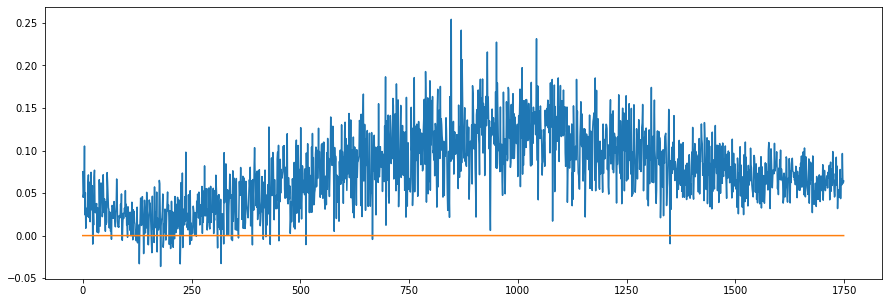

In [34]:
plt.figure(figsize=(15,5))
plt.plot(range(len(kld)), kld)
plt.plot(range(len(kld)), np.ones(len(kld))*0);

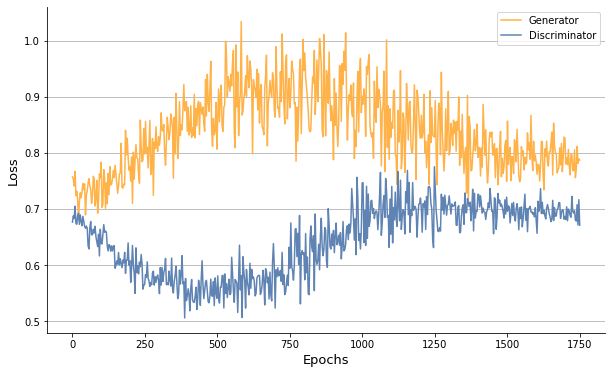

In [35]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

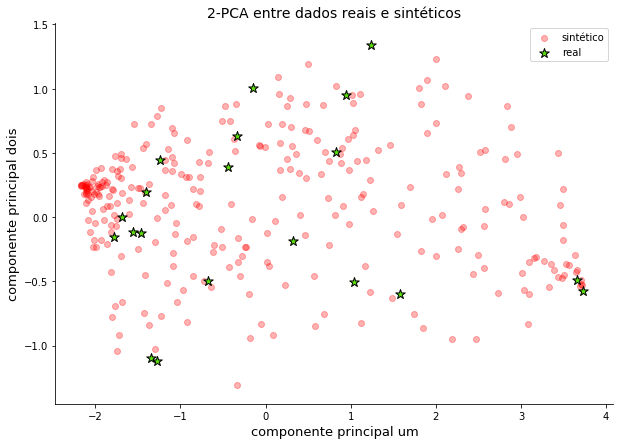

In [36]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [37]:

from sklearn.svm import OneClassSVM
#nu=0.0112

clf = OneClassSVM(kernel="rbf", nu=0.01, gamma=1/X_nov.shape[1], max_iter=-1).fit(X_nov) #0.0138

print("train recall score: ", recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train recall score in the RG: ", recall_score(np.ones(14), clf.predict(X_train[:14])))
print("test recall score in the RG: ", accuracy_score(np.ones(6),clf.predict(X_train[14:]) ))
print("recall em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("------------------------------------------------------")

predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

train recall score:  0.9713375796178344
train recall score in the RG:  0.7142857142857143
test recall score in the RG:  0.8333333333333334
recall em todos os genes de referência:  0.75
------------------------------------------------------


((871, 9), (3297, 9))

In [38]:
sc, df = clf.score_samples(X_nov), clf.decision_function(X_nov)


In [39]:
sc[np.where(df<0)], np.where(df<0)

(array([1.17656207, 1.17694815, 1.17709089, 1.17689748, 1.17702826,
        1.1770189 , 1.17686769, 1.17694814, 1.17706857]),
 (array([  6,   7,  10,  12,  73, 112, 125, 186, 199]),))

In [40]:
np.sort(sc)[:len(sc[np.where(df<0)])] == np.sort(sc[np.where(df<0)])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [117]:
min_pre = np.inf
l_dist = []
for i in range(300):
    t_i = time()
    noise_input = 50
    ep = 1700
    #Gerador
    optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
    #optimizerG = SGD(lr=0.00011, momentum=0.92)
    obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
    G = obj_G.compileG()
    # Discriminador
    optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
    #optimizerD = SGD(lr=0.001, momentum=0.9)
    objD = Discriminator((X_train.shape[1],), optimizerD)
    D = objD.compileD()
    gan = Gan(G,D)
    gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
    w_i = gan.get_weights().copy()
    g_loss, d_loss, precision, recall, _ = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input, verbose=False)
    l_pre = []
    for k in range(50):
        X_gen = G.predict(np.random.normal(0, 1, (300, noise_input)))
        y_proba = D.predict_proba(X_gen)
        d = []
        for g in range(X_train.shape[0]):
            d.append(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
        l_pre.append(np.mean(np.array(d)) + np.mean((1-y_proba)*np.log((1-y_proba)/y_proba)))
    l_dist.append(np.mean(np.array(l_pre)))
    if np.mean(np.array(l_pre)) < min_pre:
        min_pre = np.mean(np.array(l_pre))
        w_best = w_i
    t_f = time()
    print("iteração: ",i," ", np.round(t_f-t_i,4), "[s]")

iteração:  0   40.2756 [s]
iteração:  1   35.6382 [s]
iteração:  2   36.9512 [s]
iteração:  3   37.7221 [s]
iteração:  4   38.825 [s]
iteração:  5   43.4459 [s]
iteração:  6   41.2034 [s]


KeyboardInterrupt: 

In [118]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_63 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_64 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [119]:
gan.get_weights()[0][0][0]

-0.21924835

In [123]:
gan.set_weights(w_best)
gan.get_weights()[0][0][0]

-0.056016892

In [124]:
g_loss, d_loss, precision, recall, _ = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.832933],[Generator::loss: 0.869841], 0.030039[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.837276],[Generator::loss: 0.862435], 0.031574[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.820949],[Generator::loss: 0.738817], 0.029147[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.837234],[Generator::loss: 0.832955], 0.023028[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.838714],[Generator::loss: 0.774004], 0.022121[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.844661],[Generator::loss: 0.823958], 0.026624[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.833097],[Generator::loss: 0.864753], 0.020882[sec]
epoch:[8/1700] [Discriminator::d_loss: 0.836056],[Generator::loss: 0.762465], 0.019243[sec]
epoch:[9/1700] [Discriminator::d_loss: 0.804297],[Generator::loss: 0.838824], 0.019250[sec]
epoch:[10/1700] [Discriminator::d_loss: 0.833256],[Generator::loss: 0.859831], 0.026198[sec]
epoch:[11/1700] [Discriminator::d_loss: 0.815501],[Generator::loss: 0.744446], 

epoch:[94/1700] [Discriminator::d_loss: 0.691920],[Generator::loss: 0.675389], 0.025436[sec]
epoch:[95/1700] [Discriminator::d_loss: 0.639557],[Generator::loss: 0.698198], 0.029203[sec]
epoch:[96/1700] [Discriminator::d_loss: 0.654297],[Generator::loss: 0.669266], 0.029256[sec]
epoch:[97/1700] [Discriminator::d_loss: 0.663563],[Generator::loss: 0.667305], 0.023431[sec]
epoch:[98/1700] [Discriminator::d_loss: 0.633529],[Generator::loss: 0.733455], 0.022373[sec]
epoch:[99/1700] [Discriminator::d_loss: 0.650359],[Generator::loss: 0.714218], 0.019585[sec]
epoch:[100/1700] [Discriminator::d_loss: 0.626030],[Generator::loss: 0.685739], 0.021131[sec]
epoch:[101/1700] [Discriminator::d_loss: 0.637936],[Generator::loss: 0.710711], 0.019247[sec]
epoch:[102/1700] [Discriminator::d_loss: 0.614833],[Generator::loss: 0.720262], 0.018974[sec]
epoch:[103/1700] [Discriminator::d_loss: 0.637956],[Generator::loss: 0.682268], 0.020752[sec]
epoch:[104/1700] [Discriminator::d_loss: 0.657470],[Generator::los

epoch:[183/1700] [Discriminator::d_loss: 0.602424],[Generator::loss: 0.788355], 0.021291[sec]
epoch:[184/1700] [Discriminator::d_loss: 0.599130],[Generator::loss: 0.752536], 0.025877[sec]
epoch:[185/1700] [Discriminator::d_loss: 0.582366],[Generator::loss: 0.780975], 0.020546[sec]
epoch:[186/1700] [Discriminator::d_loss: 0.585403],[Generator::loss: 0.770999], 0.019642[sec]
epoch:[187/1700] [Discriminator::d_loss: 0.636717],[Generator::loss: 0.757243], 0.029484[sec]
epoch:[188/1700] [Discriminator::d_loss: 0.634902],[Generator::loss: 0.699451], 0.030313[sec]
epoch:[189/1700] [Discriminator::d_loss: 0.633561],[Generator::loss: 0.717069], 0.030835[sec]
epoch:[190/1700] [Discriminator::d_loss: 0.604887],[Generator::loss: 0.762159], 0.033964[sec]
epoch:[191/1700] [Discriminator::d_loss: 0.592773],[Generator::loss: 0.790946], 0.035466[sec]
epoch:[192/1700] [Discriminator::d_loss: 0.594592],[Generator::loss: 0.740434], 0.027490[sec]
epoch:[193/1700] [Discriminator::d_loss: 0.582781],[Generato

epoch:[280/1700] [Discriminator::d_loss: 0.601453],[Generator::loss: 0.772849], 0.019496[sec]
epoch:[281/1700] [Discriminator::d_loss: 0.576382],[Generator::loss: 0.865773], 0.023341[sec]
epoch:[282/1700] [Discriminator::d_loss: 0.551121],[Generator::loss: 0.849062], 0.020321[sec]
epoch:[283/1700] [Discriminator::d_loss: 0.583124],[Generator::loss: 0.868800], 0.020066[sec]
epoch:[284/1700] [Discriminator::d_loss: 0.562643],[Generator::loss: 0.816710], 0.019507[sec]
epoch:[285/1700] [Discriminator::d_loss: 0.573342],[Generator::loss: 0.855109], 0.018939[sec]
epoch:[286/1700] [Discriminator::d_loss: 0.555965],[Generator::loss: 0.813761], 0.018917[sec]
epoch:[287/1700] [Discriminator::d_loss: 0.576837],[Generator::loss: 0.875961], 0.019543[sec]
epoch:[288/1700] [Discriminator::d_loss: 0.559464],[Generator::loss: 0.797161], 0.021503[sec]
epoch:[289/1700] [Discriminator::d_loss: 0.578630],[Generator::loss: 0.800477], 0.019120[sec]
epoch:[290/1700] [Discriminator::d_loss: 0.623294],[Generato

epoch:[373/1700] [Discriminator::d_loss: 0.636978],[Generator::loss: 0.839988], 0.019539[sec]
epoch:[374/1700] [Discriminator::d_loss: 0.599331],[Generator::loss: 0.938444], 0.022806[sec]
epoch:[375/1700] [Discriminator::d_loss: 0.606012],[Generator::loss: 0.927207], 0.021342[sec]
epoch:[376/1700] [Discriminator::d_loss: 0.547586],[Generator::loss: 0.882614], 0.019909[sec]
epoch:[377/1700] [Discriminator::d_loss: 0.579954],[Generator::loss: 0.947463], 0.019170[sec]
epoch:[378/1700] [Discriminator::d_loss: 0.565687],[Generator::loss: 0.853164], 0.019043[sec]
epoch:[379/1700] [Discriminator::d_loss: 0.574164],[Generator::loss: 0.822166], 0.019078[sec]
epoch:[380/1700] [Discriminator::d_loss: 0.556776],[Generator::loss: 0.863630], 0.020938[sec]
epoch:[381/1700] [Discriminator::d_loss: 0.583058],[Generator::loss: 0.904929], 0.018923[sec]
epoch:[382/1700] [Discriminator::d_loss: 0.562181],[Generator::loss: 1.013333], 0.019123[sec]
epoch:[383/1700] [Discriminator::d_loss: 0.575893],[Generato

epoch:[464/1700] [Discriminator::d_loss: 0.568341],[Generator::loss: 0.872934], 0.021849[sec]
epoch:[465/1700] [Discriminator::d_loss: 0.528938],[Generator::loss: 0.888018], 0.029464[sec]
epoch:[466/1700] [Discriminator::d_loss: 0.584232],[Generator::loss: 0.961809], 0.020279[sec]
epoch:[467/1700] [Discriminator::d_loss: 0.526551],[Generator::loss: 0.962101], 0.020934[sec]
epoch:[468/1700] [Discriminator::d_loss: 0.555296],[Generator::loss: 0.927991], 0.020495[sec]
epoch:[469/1700] [Discriminator::d_loss: 0.556923],[Generator::loss: 0.829543], 0.019122[sec]
epoch:[470/1700] [Discriminator::d_loss: 0.599123],[Generator::loss: 0.941324], 0.018773[sec]
epoch:[471/1700] [Discriminator::d_loss: 0.542494],[Generator::loss: 0.951445], 0.019326[sec]
epoch:[472/1700] [Discriminator::d_loss: 0.539539],[Generator::loss: 0.867086], 0.021449[sec]
epoch:[473/1700] [Discriminator::d_loss: 0.565779],[Generator::loss: 0.882978], 0.020023[sec]
epoch:[474/1700] [Discriminator::d_loss: 0.612338],[Generato

epoch:[555/1700] [Discriminator::d_loss: 0.632543],[Generator::loss: 0.870634], 0.020456[sec]
epoch:[556/1700] [Discriminator::d_loss: 0.582126],[Generator::loss: 0.923138], 0.032151[sec]
epoch:[557/1700] [Discriminator::d_loss: 0.559471],[Generator::loss: 0.895958], 0.020116[sec]
epoch:[558/1700] [Discriminator::d_loss: 0.556957],[Generator::loss: 0.904476], 0.020266[sec]
epoch:[559/1700] [Discriminator::d_loss: 0.568180],[Generator::loss: 0.941053], 0.019824[sec]
epoch:[560/1700] [Discriminator::d_loss: 0.607400],[Generator::loss: 0.782790], 0.021765[sec]
epoch:[561/1700] [Discriminator::d_loss: 0.618016],[Generator::loss: 0.950045], 0.019800[sec]
epoch:[562/1700] [Discriminator::d_loss: 0.514791],[Generator::loss: 0.869297], 0.019111[sec]
epoch:[563/1700] [Discriminator::d_loss: 0.598538],[Generator::loss: 0.933148], 0.020178[sec]
epoch:[564/1700] [Discriminator::d_loss: 0.591700],[Generator::loss: 0.973060], 0.020283[sec]
epoch:[565/1700] [Discriminator::d_loss: 0.562629],[Generato

epoch:[648/1700] [Discriminator::d_loss: 0.618846],[Generator::loss: 0.843832], 0.021720[sec]
epoch:[649/1700] [Discriminator::d_loss: 0.560136],[Generator::loss: 0.883624], 0.020926[sec]
epoch:[650/1700] [Discriminator::d_loss: 0.599213],[Generator::loss: 0.932005], 0.019350[sec]
epoch:[651/1700] [Discriminator::d_loss: 0.565279],[Generator::loss: 0.880966], 0.019550[sec]
epoch:[652/1700] [Discriminator::d_loss: 0.614194],[Generator::loss: 0.777072], 0.020041[sec]
epoch:[653/1700] [Discriminator::d_loss: 0.559038],[Generator::loss: 0.954543], 0.019192[sec]
epoch:[654/1700] [Discriminator::d_loss: 0.604769],[Generator::loss: 0.885350], 0.018991[sec]
epoch:[655/1700] [Discriminator::d_loss: 0.592949],[Generator::loss: 0.967926], 0.019155[sec]
epoch:[656/1700] [Discriminator::d_loss: 0.575652],[Generator::loss: 0.965243], 0.020217[sec]
epoch:[657/1700] [Discriminator::d_loss: 0.553437],[Generator::loss: 0.943770], 0.020970[sec]
epoch:[658/1700] [Discriminator::d_loss: 0.579998],[Generato

epoch:[739/1700] [Discriminator::d_loss: 0.616465],[Generator::loss: 0.871403], 0.021451[sec]
epoch:[740/1700] [Discriminator::d_loss: 0.598875],[Generator::loss: 0.904675], 0.023171[sec]
epoch:[741/1700] [Discriminator::d_loss: 0.622250],[Generator::loss: 0.890058], 0.019648[sec]
epoch:[742/1700] [Discriminator::d_loss: 0.636006],[Generator::loss: 0.940247], 0.019305[sec]
epoch:[743/1700] [Discriminator::d_loss: 0.586282],[Generator::loss: 0.916582], 0.019413[sec]
epoch:[744/1700] [Discriminator::d_loss: 0.637634],[Generator::loss: 0.846246], 0.020673[sec]
epoch:[745/1700] [Discriminator::d_loss: 0.534103],[Generator::loss: 0.882435], 0.019042[sec]
epoch:[746/1700] [Discriminator::d_loss: 0.610371],[Generator::loss: 0.974909], 0.019204[sec]
epoch:[747/1700] [Discriminator::d_loss: 0.621502],[Generator::loss: 0.866850], 0.018806[sec]
epoch:[748/1700] [Discriminator::d_loss: 0.618207],[Generator::loss: 0.937417], 0.018897[sec]
epoch:[749/1700] [Discriminator::d_loss: 0.624623],[Generato

epoch:[831/1700] [Discriminator::d_loss: 0.620745],[Generator::loss: 0.901876], 0.019554[sec]
epoch:[832/1700] [Discriminator::d_loss: 0.615074],[Generator::loss: 0.921563], 0.029845[sec]
epoch:[833/1700] [Discriminator::d_loss: 0.586464],[Generator::loss: 0.845526], 0.019643[sec]
epoch:[834/1700] [Discriminator::d_loss: 0.599347],[Generator::loss: 0.902811], 0.019696[sec]
epoch:[835/1700] [Discriminator::d_loss: 0.617958],[Generator::loss: 0.853500], 0.019410[sec]
epoch:[836/1700] [Discriminator::d_loss: 0.580866],[Generator::loss: 0.842051], 0.018859[sec]
epoch:[837/1700] [Discriminator::d_loss: 0.602682],[Generator::loss: 0.897441], 0.022419[sec]
epoch:[838/1700] [Discriminator::d_loss: 0.584533],[Generator::loss: 0.917233], 0.019079[sec]
epoch:[839/1700] [Discriminator::d_loss: 0.650984],[Generator::loss: 0.912033], 0.019482[sec]
epoch:[840/1700] [Discriminator::d_loss: 0.645959],[Generator::loss: 0.869300], 0.019231[sec]
epoch:[841/1700] [Discriminator::d_loss: 0.642358],[Generato

epoch:[922/1700] [Discriminator::d_loss: 0.670451],[Generator::loss: 0.852458], 0.022952[sec]
epoch:[923/1700] [Discriminator::d_loss: 0.652328],[Generator::loss: 0.865082], 0.026532[sec]
epoch:[924/1700] [Discriminator::d_loss: 0.663531],[Generator::loss: 0.882789], 0.020035[sec]
epoch:[925/1700] [Discriminator::d_loss: 0.641156],[Generator::loss: 0.908566], 0.019574[sec]
epoch:[926/1700] [Discriminator::d_loss: 0.684314],[Generator::loss: 0.909715], 0.019587[sec]
epoch:[927/1700] [Discriminator::d_loss: 0.618042],[Generator::loss: 0.909359], 0.019037[sec]
epoch:[928/1700] [Discriminator::d_loss: 0.641895],[Generator::loss: 0.841214], 0.021230[sec]
epoch:[929/1700] [Discriminator::d_loss: 0.640230],[Generator::loss: 0.871754], 0.019231[sec]
epoch:[930/1700] [Discriminator::d_loss: 0.632833],[Generator::loss: 0.797138], 0.019278[sec]
epoch:[931/1700] [Discriminator::d_loss: 0.658805],[Generator::loss: 0.858751], 0.019160[sec]
epoch:[932/1700] [Discriminator::d_loss: 0.629061],[Generato

epoch:[1014/1700] [Discriminator::d_loss: 0.621901],[Generator::loss: 0.833372], 0.026784[sec]
epoch:[1015/1700] [Discriminator::d_loss: 0.633112],[Generator::loss: 0.829298], 0.021981[sec]
epoch:[1016/1700] [Discriminator::d_loss: 0.657614],[Generator::loss: 0.842917], 0.021097[sec]
epoch:[1017/1700] [Discriminator::d_loss: 0.631587],[Generator::loss: 0.771526], 0.018930[sec]
epoch:[1018/1700] [Discriminator::d_loss: 0.677685],[Generator::loss: 0.859504], 0.021297[sec]
epoch:[1019/1700] [Discriminator::d_loss: 0.669014],[Generator::loss: 0.763300], 0.019399[sec]
epoch:[1020/1700] [Discriminator::d_loss: 0.640231],[Generator::loss: 0.892819], 0.021045[sec]
epoch:[1021/1700] [Discriminator::d_loss: 0.663370],[Generator::loss: 0.810089], 0.019525[sec]
epoch:[1022/1700] [Discriminator::d_loss: 0.684799],[Generator::loss: 0.900125], 0.019103[sec]
epoch:[1023/1700] [Discriminator::d_loss: 0.616313],[Generator::loss: 0.836143], 0.018995[sec]
epoch:[1024/1700] [Discriminator::d_loss: 0.643474

epoch:[1109/1700] [Discriminator::d_loss: 0.691634],[Generator::loss: 0.834367], 0.027154[sec]
epoch:[1110/1700] [Discriminator::d_loss: 0.663321],[Generator::loss: 0.787461], 0.020182[sec]
epoch:[1111/1700] [Discriminator::d_loss: 0.675397],[Generator::loss: 0.802119], 0.019172[sec]
epoch:[1112/1700] [Discriminator::d_loss: 0.674511],[Generator::loss: 0.849969], 0.019189[sec]
epoch:[1113/1700] [Discriminator::d_loss: 0.666928],[Generator::loss: 0.801908], 0.021349[sec]
epoch:[1114/1700] [Discriminator::d_loss: 0.683788],[Generator::loss: 0.793582], 0.019115[sec]
epoch:[1115/1700] [Discriminator::d_loss: 0.654982],[Generator::loss: 0.899454], 0.020891[sec]
epoch:[1116/1700] [Discriminator::d_loss: 0.659737],[Generator::loss: 0.841067], 0.019197[sec]
epoch:[1117/1700] [Discriminator::d_loss: 0.644050],[Generator::loss: 0.794831], 0.018772[sec]
epoch:[1118/1700] [Discriminator::d_loss: 0.700013],[Generator::loss: 0.852394], 0.020522[sec]
epoch:[1119/1700] [Discriminator::d_loss: 0.639787

epoch:[1201/1700] [Discriminator::d_loss: 0.641864],[Generator::loss: 0.877634], 0.021273[sec]
epoch:[1202/1700] [Discriminator::d_loss: 0.723710],[Generator::loss: 0.824598], 0.022634[sec]
epoch:[1203/1700] [Discriminator::d_loss: 0.697254],[Generator::loss: 0.807861], 0.019747[sec]
epoch:[1204/1700] [Discriminator::d_loss: 0.706735],[Generator::loss: 0.781506], 0.018983[sec]
epoch:[1205/1700] [Discriminator::d_loss: 0.671025],[Generator::loss: 0.856895], 0.018941[sec]
epoch:[1206/1700] [Discriminator::d_loss: 0.677552],[Generator::loss: 0.817775], 0.022507[sec]
epoch:[1207/1700] [Discriminator::d_loss: 0.688942],[Generator::loss: 0.865819], 0.019341[sec]
epoch:[1208/1700] [Discriminator::d_loss: 0.703568],[Generator::loss: 0.805337], 0.018993[sec]
epoch:[1209/1700] [Discriminator::d_loss: 0.644551],[Generator::loss: 0.907306], 0.019199[sec]
epoch:[1210/1700] [Discriminator::d_loss: 0.648041],[Generator::loss: 0.803827], 0.019856[sec]
epoch:[1211/1700] [Discriminator::d_loss: 0.691057

epoch:[1291/1700] [Discriminator::d_loss: 0.710390],[Generator::loss: 0.791598], 0.019883[sec]
epoch:[1292/1700] [Discriminator::d_loss: 0.669450],[Generator::loss: 0.831087], 0.022854[sec]
epoch:[1293/1700] [Discriminator::d_loss: 0.715445],[Generator::loss: 0.777352], 0.022195[sec]
epoch:[1294/1700] [Discriminator::d_loss: 0.668911],[Generator::loss: 0.847240], 0.019638[sec]
epoch:[1295/1700] [Discriminator::d_loss: 0.696768],[Generator::loss: 0.802889], 0.018827[sec]
epoch:[1296/1700] [Discriminator::d_loss: 0.672618],[Generator::loss: 0.724618], 0.019049[sec]
epoch:[1297/1700] [Discriminator::d_loss: 0.654797],[Generator::loss: 0.788619], 0.019091[sec]
epoch:[1298/1700] [Discriminator::d_loss: 0.663597],[Generator::loss: 0.806417], 0.022191[sec]
epoch:[1299/1700] [Discriminator::d_loss: 0.674929],[Generator::loss: 0.831024], 0.019254[sec]
epoch:[1300/1700] [Discriminator::d_loss: 0.667253],[Generator::loss: 0.810852], 0.019185[sec]
epoch:[1301/1700] [Discriminator::d_loss: 0.694216

epoch:[1381/1700] [Discriminator::d_loss: 0.671517],[Generator::loss: 0.766031], 0.022330[sec]
epoch:[1382/1700] [Discriminator::d_loss: 0.674989],[Generator::loss: 0.772688], 0.023529[sec]
epoch:[1383/1700] [Discriminator::d_loss: 0.670886],[Generator::loss: 0.754856], 0.020709[sec]
epoch:[1384/1700] [Discriminator::d_loss: 0.665066],[Generator::loss: 0.772747], 0.020299[sec]
epoch:[1385/1700] [Discriminator::d_loss: 0.686643],[Generator::loss: 0.803528], 0.019951[sec]
epoch:[1386/1700] [Discriminator::d_loss: 0.729737],[Generator::loss: 0.794443], 0.019138[sec]
epoch:[1387/1700] [Discriminator::d_loss: 0.668451],[Generator::loss: 0.823270], 0.019057[sec]
epoch:[1388/1700] [Discriminator::d_loss: 0.678138],[Generator::loss: 0.810240], 0.019393[sec]
epoch:[1389/1700] [Discriminator::d_loss: 0.678549],[Generator::loss: 0.793460], 0.020391[sec]
epoch:[1390/1700] [Discriminator::d_loss: 0.707958],[Generator::loss: 0.773543], 0.020182[sec]
epoch:[1391/1700] [Discriminator::d_loss: 0.656276

epoch:[1471/1700] [Discriminator::d_loss: 0.678726],[Generator::loss: 0.710200], 0.020376[sec]
epoch:[1472/1700] [Discriminator::d_loss: 0.660754],[Generator::loss: 0.776043], 0.023898[sec]
epoch:[1473/1700] [Discriminator::d_loss: 0.704854],[Generator::loss: 0.768967], 0.021121[sec]
epoch:[1474/1700] [Discriminator::d_loss: 0.687980],[Generator::loss: 0.709199], 0.019111[sec]
epoch:[1475/1700] [Discriminator::d_loss: 0.700874],[Generator::loss: 0.788551], 0.019309[sec]
epoch:[1476/1700] [Discriminator::d_loss: 0.704999],[Generator::loss: 0.789815], 0.019616[sec]
epoch:[1477/1700] [Discriminator::d_loss: 0.691183],[Generator::loss: 0.737983], 0.020361[sec]
epoch:[1478/1700] [Discriminator::d_loss: 0.669351],[Generator::loss: 0.802253], 0.023188[sec]
epoch:[1479/1700] [Discriminator::d_loss: 0.698409],[Generator::loss: 0.728026], 0.021486[sec]
epoch:[1480/1700] [Discriminator::d_loss: 0.698760],[Generator::loss: 0.817971], 0.019194[sec]
epoch:[1481/1700] [Discriminator::d_loss: 0.693013

epoch:[1561/1700] [Discriminator::d_loss: 0.669841],[Generator::loss: 0.746748], 0.020697[sec]
epoch:[1562/1700] [Discriminator::d_loss: 0.709513],[Generator::loss: 0.789412], 0.022395[sec]
epoch:[1563/1700] [Discriminator::d_loss: 0.673494],[Generator::loss: 0.729051], 0.020968[sec]
epoch:[1564/1700] [Discriminator::d_loss: 0.690846],[Generator::loss: 0.743231], 0.019353[sec]
epoch:[1565/1700] [Discriminator::d_loss: 0.676430],[Generator::loss: 0.763496], 0.019090[sec]
epoch:[1566/1700] [Discriminator::d_loss: 0.714240],[Generator::loss: 0.765539], 0.018991[sec]
epoch:[1567/1700] [Discriminator::d_loss: 0.698122],[Generator::loss: 0.695984], 0.018999[sec]
epoch:[1568/1700] [Discriminator::d_loss: 0.684304],[Generator::loss: 0.765218], 0.020518[sec]
epoch:[1569/1700] [Discriminator::d_loss: 0.699886],[Generator::loss: 0.773461], 0.021252[sec]
epoch:[1570/1700] [Discriminator::d_loss: 0.687731],[Generator::loss: 0.683163], 0.019028[sec]
epoch:[1571/1700] [Discriminator::d_loss: 0.693072

epoch:[1651/1700] [Discriminator::d_loss: 0.686641],[Generator::loss: 0.769752], 0.023579[sec]
epoch:[1652/1700] [Discriminator::d_loss: 0.722920],[Generator::loss: 0.716794], 0.021816[sec]
epoch:[1653/1700] [Discriminator::d_loss: 0.688714],[Generator::loss: 0.761335], 0.019980[sec]
epoch:[1654/1700] [Discriminator::d_loss: 0.700249],[Generator::loss: 0.703755], 0.020656[sec]
epoch:[1655/1700] [Discriminator::d_loss: 0.686563],[Generator::loss: 0.773652], 0.019977[sec]
epoch:[1656/1700] [Discriminator::d_loss: 0.686862],[Generator::loss: 0.799935], 0.019486[sec]
epoch:[1657/1700] [Discriminator::d_loss: 0.689404],[Generator::loss: 0.749589], 0.019260[sec]
epoch:[1658/1700] [Discriminator::d_loss: 0.679890],[Generator::loss: 0.775560], 0.018974[sec]
epoch:[1659/1700] [Discriminator::d_loss: 0.695219],[Generator::loss: 0.749331], 0.020217[sec]
epoch:[1660/1700] [Discriminator::d_loss: 0.687137],[Generator::loss: 0.703234], 0.020080[sec]
epoch:[1661/1700] [Discriminator::d_loss: 0.716890

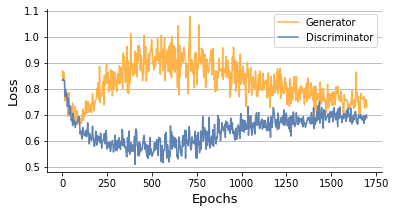

In [125]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/loss.svg');

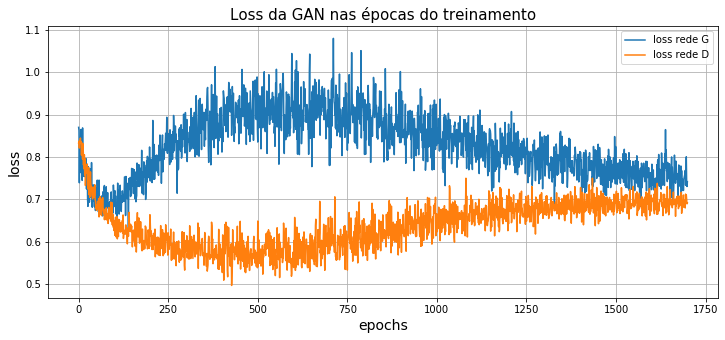

In [126]:
fig = plt.figure(figsize=(12,5))

plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

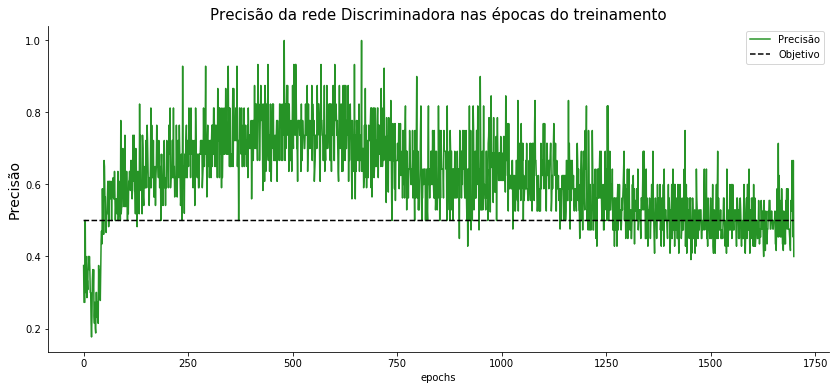

In [127]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

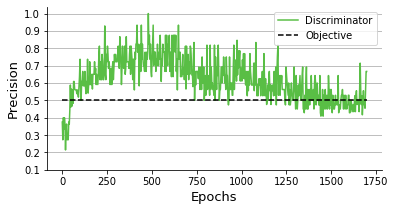

In [128]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_precision, color="#59BE45", alpha=1, label="Discriminator");
plt.plot(rr,np.ones(len(short_precision))*.5,
         color="black", ls="--", label="Objective");
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.yticks(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
           np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
plt.grid(axis="y")
plt.legend();
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/precision.svg');

In [0]:
#gan.save("./drive/My Drive/Colab Notebooks/data/best_gan27012020.h5")

In [114]:
from tensorflow.keras.models import load_model

gan_save = load_model("./results/best_gan27012020.h5")
weights_save = gan_save.get_weights()
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()
gan.set_weights(weights_save)

Dimension del ruido de entrada:  50
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_25 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


(20, 2) (300, 2)


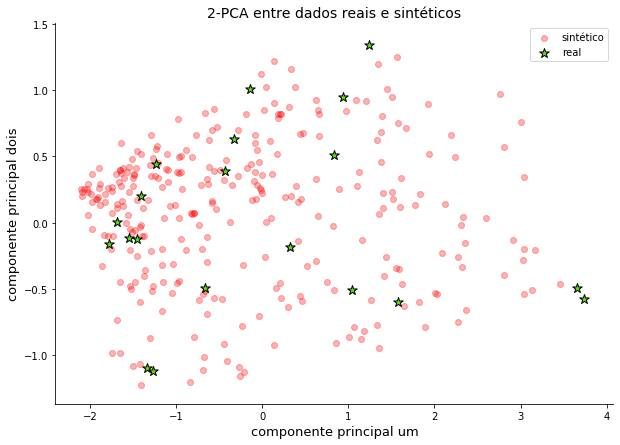

In [27]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(0, 1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [129]:
m_precision = []
m_recall = []
m_f1score = []
m_accuracy = []
t_gi = time()
for i in range(5000):
    t_i = time()
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    m_precision.append(precision_score(y_test, y_predict))
    m_recall.append(recall_score(y_test, y_predict))
    m_f1score.append(f1_score(y_test, y_predict))
    m_accuracy.append(accuracy_score(y_test, y_predict))
    if i%500 == 0:
        t_f = time()
        print ('iteration:[%d/%d], time: %f' % (i, 5000, t_f-t_i))
t_gf = time()
print("global time: ", (t_gf-t_gi)/60, "[s]")

iteration:[0/5000], time: 0.011730
iteration:[500/5000], time: 0.008095
iteration:[1000/5000], time: 0.007998
iteration:[1500/5000], time: 0.008860
iteration:[2000/5000], time: 0.010083
iteration:[2500/5000], time: 0.008498
iteration:[3000/5000], time: 0.009019
iteration:[3500/5000], time: 0.009395
iteration:[4000/5000], time: 0.008354
iteration:[4500/5000], time: 0.008405
global time:  0.7489576220512391 [s]


In [130]:
def boxtplot_values(v):
    """
    return the values to plot a boxplot with ouliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]
    
    return [lower, q25, q50, q75, upper], outliers

### Boxplot das métricas do Discriminador

In [131]:
[pl, pq1, pq2, pq3, pu], pouts = boxtplot_values(np.array(m_precision))
[rl, rq1, rq2, rq3, ru], routs = boxtplot_values(np.array(m_recall))
[fl, fq1, fq2, fq3, fu], fouts = boxtplot_values(np.array(m_f1score))
[al, aq1, aq2, aq3, au], aouts = boxtplot_values(np.array(m_accuracy))

In [132]:
cats = ["Accuray", "Precision", "F1-score"]
p = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=300,) # title="Discriminator metrics"


p.segment(cats, [aq3,pq3,fq3], cats, [au,pu,fu], line_color="black")
p.segment(cats, [al,pl,fl], cats, [aq1,pq1,fq1], line_color="black")
# boxes
p.vbar(cats, 0.4, [aq2,pq2,fq2], [aq3,pq3,fq3], fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.4, [aq1,pq1,fq1], [aq2,pq2,fq2], fill_color="#3B8686", line_color="black")
# whiskers
p.rect(cats, [al,pl,fl], 0.2, 0.0001, line_color="black")
p.rect(cats, [au,pu,fu], 0.2, 0.0001, line_color="black")

p.circle([cats[0] for i in range(len(np.unique(aouts)))], np.unique(aouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[1] for i in range(len(np.unique(pouts)))], np.unique(pouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[2] for i in range(len(np.unique(fouts)))], np.unique(fouts),
         size=6, color="#F38630", fill_alpha=0.6)

p.legend.background_fill_alpha = 0.0
show(p)

/home/edwin/.local/lib/python3.6/site-packages/bokeh/models/plots.py:767: UserWarning: 
You are attempting to set `plot.legend.background_fill_alpha` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


In [133]:
np.arange(0.2,1,0.05)

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95])

In [134]:
print("----------------------------")
print("---- accuracy metrics -----")
print("----------------------------")
print("mean accuracy: ", np.round(np.mean(m_accuracy),4))
print("median accuracy: ", np.round(np.median(m_accuracy),4))
print("std accuracy: ", np.round(np.std(m_accuracy),4))
print("----------------------------")
print("---- precision metrics -----")
print("----------------------------")
print("mean precision: ", np.round(np.mean(m_precision),4))
print("median precision: ", np.round(np.median(m_precision),4))
print("std precision: ", np.round(np.std(m_precision),4))
print("----------------------------")
print("---- recall metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_recall),4))
print("median recall: ", np.round(np.median(m_recall),4))
print("std recall: ", np.round(np.std(m_recall),4))
print("----------------------------")
print("---- f1-score metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_f1score),4))
print("median recall: ", np.round(np.median(m_f1score),4))
print("std recall: ", np.round(np.std(m_f1score),4))

----------------------------
---- accuracy metrics -----
----------------------------
mean accuracy:  0.5017
median accuracy:  0.5
std accuracy:  0.0555
----------------------------
---- precision metrics -----
----------------------------
mean precision:  0.5082
median precision:  0.5
std precision:  0.059
----------------------------
---- recall metrics -----
----------------------------
mean recall:  0.5
median recall:  0.5
std recall:  0.0
----------------------------
---- f1-score metrics -----
----------------------------
mean recall:  0.5024
median recall:  0.5
std recall:  0.0282


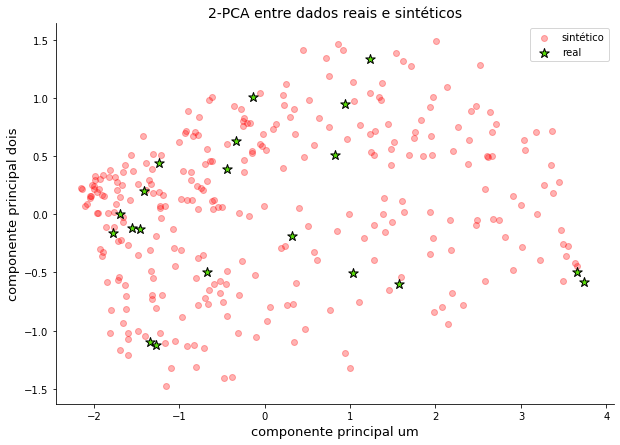

In [135]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [138]:
def best_sample(generator, n_synt, n_samples, noise_input):
    """
    return the best sample of the list the n_samples
    generated by the generator.
    """
    cv_dict = {}
    best_score = np.inf
    best_idx = np.inf
    for i in range(n_samples):
        x_pred = generator.predict(np.random.normal(0, 1, (n_synt, noise_input)))
        x_trans = obj.inverse_transform(x_pred)
        #coefficient of variation
        cv = np.median(np.std(x_trans, axis=1)/np.mean(x_trans, axis=1))
        if cv < best_score:
            best_score = cv
            best_idx = i
        cv_dict[i] = (cv, x_pred)
    return cv_dict, best_idx

In [139]:
t_i = time()
dt_cv, best_idx = best_sample(G, 300, 5000, noise_input)
t_f = time()
print("tempo de execuçฺão: ", (t_f-t_i), "[s]")
print(dt_cv[best_idx][0], best_idx)

tempo de execuçฺão:  62.555264711380005 [s]
0.1401170050001582 1830


In [140]:
c_v = []
for i in dt_cv.keys():
    c_v.append(dt_cv[i][0])

0.17067265947867105


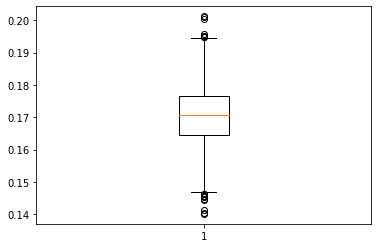

In [141]:
print(np.median(c_v))
plt.boxplot(c_v,);

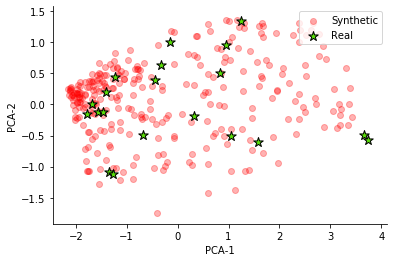

In [142]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(dt_cv[best_idx][1])

#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="Synthetic", alpha=.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend(loc="upper right");
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/new_data.svg');

In [143]:
#ENTRENANDO EL CLASIFICADOR SOLO CON LOS GENES DE REFERENCIA

from sklearn.svm import OneClassSVM
#nu=0.138

X_normal = X_train
clf = OneClassSVM(kernel="rbf", nu=0.0112, gamma=1/9).fit(X_normal[:14]) #0.0138

print("train accuracy: ", accuracy_score(np.ones(14),clf.predict(X_normal[:14])))
print("test accuracy in the RG: ", accuracy_score(np.ones(6),clf.predict(X_normal[14:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_normal.shape[0]),clf.predict(X_normal)))
print("------------------------------------------------------")

predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

train accuracy:  0.6428571428571429
test accuracy in the RG:  0.6666666666666666
accuray em todos os genes de referência:  0.65
------------------------------------------------------


((680, 9), (3488, 9))

In [144]:
X_nov = np.concatenate((X_train[:14], dt_cv[best_idx][1]))
X_nov.shape

(314, 9)

train accuracy in the augmented data:  0.9777070063694268
train accuracy in the RG:  0.7857142857142857
test accuracy in the RG:  0.8571428571428571
accuray em todos os genes de referência:  0.8
------------------------------------------------------
train accuracy in the augmented data:  0.9777070063694268
train accuracy in the RG:  0.7857142857142857
test accuracy in the RG:  0.8571428571428571
accuray em todos os genes de referência:  0.8
accuracy de solo datos sintéticos:  0.9643333333333334


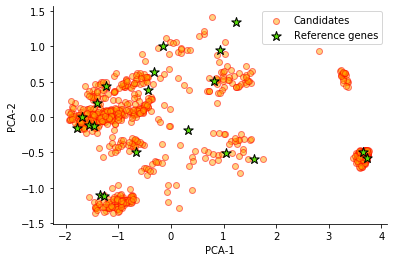

In [147]:

from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.001, gamma="auto").fit(X_nov) #0.0138

print("train accuracy in the augmented data: ", accuracy_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", accuracy_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", accuracy_score(np.ones(7),clf.predict(X_train[13:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("------------------------------------------------------")

print("train accuracy in the augmented data: ", recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", recall_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", recall_score(np.ones(7),clf.predict(X_train[13:])))
print("accuray em todos os genes de referência: ", recall_score(np.ones(X_train.shape[0]),clf.predict(X_train)))

print("accuracy de solo datos sintéticos: ", recall_score(np.ones(3000),
                                                          clf.predict(G.predict(np.random.normal(0, 1, (3000, noise_input))))))
predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape
X_nov_pca = pca_real.transform(X_nov)
X_cand_pca = pca_real.transform(cand)
X_nocand_pca = pca_real.transform(no_cand)

fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
#plt.scatter(X_nocand_pca[:, 0], X_nocand_pca[:, 1], c='blue', s=30, edgecolors='k');
plt.scatter(X_cand_pca[:, 0], X_cand_pca[:, 1], c='orange', alpha=.5, edgecolors="red",
            label="Candidates");
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Reference genes", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/candidates.svg');

### One-class classification with SVM

In [148]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.001, gamma="auto").fit(X_nov) #0.0138

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9777070063694268
score nos genes de referência de treinamento:  0.7857142857142857
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.8


In [149]:
#gan.save("./data/best_gan.h5")

In [150]:
predict_cand = clf.predict(X_cand)

In [151]:
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

((878, 9), (3290, 9))

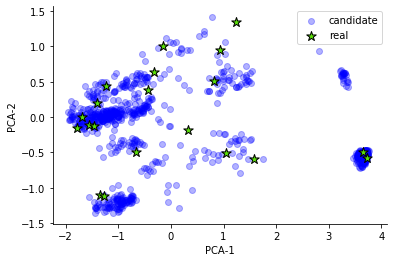

In [152]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="candidate",alpha=.3,)
#plt.scatter(X_nov_pca[:, 0], X_nov_pca[:, 1], c='red', s=30, alpha=.3, label="synthetic");
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="black", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1, marker="*", edgecolors="black", s=100)
#plt.grid()
plt.legend();

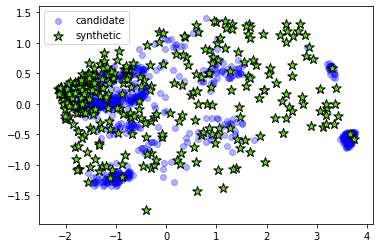

In [153]:
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="candidate",alpha=.3,)
plt.scatter(X_nov_pca[:, 0], X_nov_pca[:, 1], c='#5ADE09', s=100, alpha=1, marker="*",label="synthetic", edgecolors="black");
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="black", label="no_cand",alpha=0.1)
#plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1, marker="*", edgecolors="black", s=100)
plt.legend();

In [154]:
print("redução do ", (1 - cand.shape[0]/X_cand.shape[0])*100,"% no processo de escolha de candidatos")

redução do  78.93474088291747 % no processo de escolha de candidatos


In [155]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [157]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242


In [158]:
obj_edi = open("./data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [159]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
bamD,0.900921,0.888817,0.967560,0.940572,0.945553,0.844037,0.738203,-0.895271,0.722070
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060


## Isolation Forest

In [0]:
from sklearn.ensemble import IsolationForest

clf2 = IsolationForest(n_estimators=100, contamination=0, random_state=False,
                      behaviour="new", n_jobs=2, warm_start=True)
clf2.fit(X_nov)

print("score no treinamento: ", np.mean(clf2.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf2.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf2.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf2.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [0]:
predict_cand = clf2.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(2956, 9) (1229, 9)
redução do  29.70273483947682 % no processo de escolha de candidatos


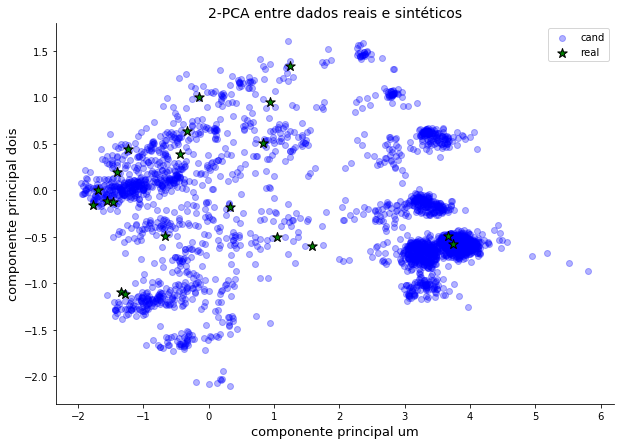

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
dtpB,-0.790432,-0.815620,0.621418,0.649137,0.668417,0.679104,0.613943,0.632987,0.645587
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
lhr,-1.035834,-1.041366,-1.066099,0.405957,-1.071559,-1.060662,-1.104705,-1.030697,-1.028057
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
pnp,1.012026,1.028689,-0.288030,-0.259168,-0.287101,-0.396191,0.954108,0.772673,0.990685


In [0]:
print(cand.loc[rg_edi].dropna().shape[0])
cand.loc[rg_edi].dropna()

12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
bamD,0.900921,0.888817,0.967560,0.940572,0.945553,0.844037,0.738203,-0.895271,0.722070
efp,0.883929,0.893426,0.986886,0.953313,0.964894,0.900637,-0.666888,0.658397,0.797629
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
polA,0.657993,0.637631,0.712010,0.686595,0.690273,-0.891506,0.583032,-0.902868,0.601666
prc,0.701789,0.687073,0.768016,0.716171,0.720595,0.659306,-0.893690,-0.953165,0.564771
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
rimP,-0.661678,0.776155,0.880130,0.877383,0.870669,0.813908,0.679395,0.567525,-0.761204
rpsO,0.938523,0.932230,-0.408265,-0.417435,-0.436328,0.963185,0.966226,0.727576,0.862091


## LocalOutlierFactor

In [0]:
from sklearn.neighbors import LocalOutlierFactor

clf3 = LocalOutlierFactor(n_neighbors=2, contamination=0.00001, novelty=True,)
clf3.fit(X_nov)

print("score no treinamento: ", np.mean(clf3.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf3.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf3.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf3.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [0]:
predict_cand = clf3.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(3344, 9) (841, 9)
redução do  20.4756242568371 % no processo de escolha de candidatos


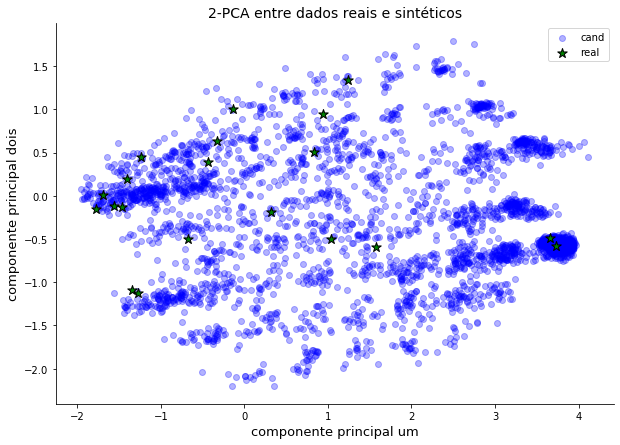

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
print(cand.loc[rg_edi].dropna().shape[0])

21
17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
